In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.loader import DataLoader
import pandas as pd
import random
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, NNConv
from tqdm import tqdm
import torch.optim as optim
import json
import pprint 
import os

from helper_function_module import init_setup
seed = 1267
device = init_setup(use_cuda = True, 
           random_seed = seed)

Using device: cpu
System CUDA Status:
- PyTorch version: 2.7.0+cu128
- CUDA Version: 12.8
- CUDA available: False

PyTorch Geometric Status:
- PyG version: 2.6.1
- torch_scatter: Installed
- torch_sparse: Installed
- torch_cluster: Installed
- torch_spline_conv: Installed


In [2]:
BASE_JSON_DATA_DIR = "/teamspace/studios/this_studio"
signal_path = os.path.join(BASE_JSON_DATA_DIR, "onlyAny2bj_onlyAny1p/ppzaxbba_ax15_200k_minpt10_15jets_etafiltered_corrected_onlyAny2bj_onlyAny1p_LorentzNet_data.json")
background_path = os.path.join(BASE_JSON_DATA_DIR, "onlyAny2bj_onlyAny1p/ppbba_500k_minpt10_15jets_etafiltered_corrected_onlyAny2bj_onlyAny1p_LorentzNet_data.json")

with open(signal_path, 'r') as file:
    signal = json.load(file)

with open(background_path, 'r') as file:
    background = json.load(file)

pp = pprint.PrettyPrinter(indent=1)

print(f"Signal Event: {len(signal)}")
print("Example:")
pp.pprint(signal[np.random.randint(0, len(signal))])
print(100*'~')

print(f"Background Event: {len(background)}")
print("Example:")
pp.pprint(background[np.random.randint(0, len(background))])

Signal Event: 3488
Example:
{'edge_index': [[0, 1, 0, 2, 0, 3, 0, 4, 1, 2, 1, 3, 1, 4, 2, 3, 2, 4, 3, 4],
                [1, 0, 2, 0, 3, 0, 4, 0, 2, 1, 3, 1, 4, 1, 3, 2, 4, 2, 4, 3]],
 'edges': [2.760954661069967,
           2.760954661069967,
           2.283724549570942,
           2.283724549570942,
           2.387841208797604,
           2.387841208797604,
           1.5105470707465558,
           1.5105470707465558,
           1.791526932228483,
           1.791526932228483,
           2.348773444643182,
           2.348773444643182,
           3.0828659199134822,
           3.0828659199134822,
           0.6269941772751961,
           0.6269941772751961,
           1.3420751460957767,
           1.3420751460957767,
           1.0808910687784408,
           1.0808910687784408],
 'event_label': 1,
 'eventno': 90895,
 'h_scalars': [[0.0, 0.0, 0.08725863854760726],
               [1.0, 0.0, 0.03044187083536501],
               [1.0, 1.0, 0.0],
               [1.0, 1.0, 0.0],
      

# Converting Each Event into a PyG Graph Object

In [3]:
from convert_to_pygData import convert_all_to_pyg_graphs
signal_pyg_graphs = convert_all_to_pyg_graphs(signal, normalize_features = False)
background_pyg_graphs = convert_all_to_pyg_graphs(background, normalize_features = False)

Initializing the process...


Progress: 100%|██████████| 3488/3488 [00:00<00:00, 4938.52it/s]


Process completed successfully :)
Initializing the process...


Progress: 100%|██████████| 5931/5931 [00:01<00:00, 4013.17it/s]

Process completed successfully :)


In [4]:
dataset = []
for data in signal_pyg_graphs + background_pyg_graphs:
    if (data.number_of_nodes >= 3):
    # & (data.num_isophotons == 1) & (data.num_btag_jets == 2):
        dataset.append(data)

random.seed(seed)
dataset = random.sample(dataset, len(dataset))
print(f'Dataset contains {len(dataset)} samples')

Dataset contains 9419 samples


In [5]:
idx = 54
print("Example Graph Data Object:")
sample_graph = dataset[idx]
print(sample_graph)

Example Graph Data Object:
Data(x=[3, 3], edge_index=[2, 6], edge_attr=[6, 1], y=0, eventno=452268, number_of_nodes=3.0, inv_mass_2j1p=119.16915130615234, inv_mass_2j=99.45587158203125, num_isophotons=1.0, num_btag_jets=2.0, node_label=[3, 1], jet_btag_label=[3, 1], isophoton_pT=13.796099662780762, h_scalars=[3, 3], x_coords=[3, 4])


In [6]:
sample_graph.jet_btag_label

tensor([[-1.],
        [ 1.],
        [ 1.]])

# Train-Test Splits

In [7]:
num_graphs = len(dataset)
train_ratio, test_ratio = 0.7, 0.3
train_size = int(train_ratio * num_graphs)
test_size = num_graphs - train_size

# Random split
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(seed)
)

print(f"Number of Graphs in:\nTraining Dataset: {len(train_dataset)}({len(train_dataset)/num_graphs:.1%})"
f"\nTest Dataset: {len(test_dataset)}({len(test_dataset)/num_graphs:.1%})")

Number of Graphs in:
Training Dataset: 6593(70.0%)
Test Dataset: 2826(30.0%)


# Classification Model Definition

In [10]:
# from LGEBwithEdgeAttr_block import LGEBConv, psi_normalization
from LGEB_block import LGEBConv, psi_normalization
import torch.nn as nn
class LorentzNet(nn.Module):
    def __init__(self, scalar_feature_dim, edge_feature_dim:int = 1, num_graph_features:int = 0,  num_lgeb_layers=3, hidden_dim=72, dropout=0.2):
        super().__init__()
        self.scalar_embedding = nn.Linear(scalar_feature_dim, hidden_dim)

        self.lgeb_layers = nn.ModuleList()
        current_scalar_dim = hidden_dim
        self.num_graph_features = num_graph_features
        for _ in range(num_lgeb_layers):
            self.lgeb_layers.append(
                LGEBConv(
                    scalar_in_channels=current_scalar_dim,
                    scalar_out_channels=hidden_dim,
                    hidden_mlp_channels=hidden_dim,
                    edge_mlp_hidden_channels=hidden_dim,
                    dropout_rate=dropout
                )
            )
            current_scalar_dim = hidden_dim 
        self.pool = global_mean_pool
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim + num_graph_features, 72),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(72, 1)
        )

    def forward(self, data):
        # data.x_coords :4-vectors [N, 4]
        # data.h_scalars : initial scalar features [N, initial_scalar_feature_dim]
        x_coords, h_scalars, edge_index, edge_attr, batch = data.x_coords, data.h_scalars, data.edge_index, data.edge_attr, data.batch

        h_scalars = F.relu(self.scalar_embedding(h_scalars))
        
        for lgeb_layer in self.lgeb_layers:
            x_coords, h_scalars = lgeb_layer(x_coords, h_scalars, edge_index)
            
        pooled_graph_embedding = self.pool(h_scalars, batch)
        
        if self.num_graph_features != 0:
            # graph_features = torch.cat([data.inv_mass_2j1p.view(-1, 1)], dim=1)
            graph_features = torch.cat([data.inv_mass_2j1p.view(-1, 1), 
                                        data.isophoton_pT.view(-1, 1)], dim=1)
            
            graph_embedding_with_graphFeat = torch.cat([pooled_graph_embedding, graph_features], dim=1)
            
            self.graph_embedding = graph_embedding_with_graphFeat
            
            out = self.classifier(graph_embedding_with_graphFeat)
        else:
            self.graph_embedding = pooled_graph_embedding
            out = self.classifier(pooled_graph_embedding)
        return torch.sigmoid(out)

In [11]:
from train_val_functions import run_training_pipeline
if __name__ == '__main__':
    model = LorentzNet(
        scalar_feature_dim = 3, 
        # edge_feature_dim = 1,
        num_graph_features = 2,
        num_lgeb_layers = 3, 
        hidden_dim = 72, 
        dropout = 0.2
    )
    EPOCHS = 50
    LEARNING_RATE = 1e-3
    BATCH_SIZE = 70

    if 'model' in locals() and 'train_dataset' in locals() and 'test_dataset' in locals():
        train_loss_lst, train_acc_lst, val_loss_lst, val_acc_lst = run_training_pipeline(
            model=model,
            train_dataset=train_dataset,
            val_dataset=test_dataset,
            num_epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            learning_rate=LEARNING_RATE,
            device_str='cuda' if torch.cuda.is_available() else 'cpu',
            model_save_path='./model_e50_withEdgeAttr_GraphFeat.pt',
            log_interval_train=1,
            verbose_frequency = 5
        )
    else:
        print("\nSkipping training loop as model or datasets are not defined in this example.")

Using device: cpu

--- Starting Training ---


Epoch 1 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 79.58it/s]


  New best validation AUC: 0.8286. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 2 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 88.97it/s]


  New best validation AUC: 0.8641. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 3 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 93.36it/s]


  New best validation AUC: 0.8778. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 4 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 86.55it/s]


  New best validation AUC: 0.8802. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 5 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 88.70it/s]



Epoch 5/50 Summary:
  Train Loss: 0.4833, Train Acc: 0.7889
  Val   Loss: 0.4260, Val   Acc: 0.8132, Val   AUC: 0.8854
  Validation F1-Score (macro avg): 0.8025
  Validation F1-Score (weighted avg): 0.8149
  New best validation AUC: 0.8854. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 6 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 94.78it/s]


  New best validation AUC: 0.8909. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 7 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 95.94it/s]


  New best validation AUC: 0.8985. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 8 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 88.55it/s]


  New best validation AUC: 0.9217. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 9 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 83.31it/s]


  New best validation AUC: 0.9250. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 10 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 70.13it/s]



Epoch 10/50 Summary:
  Train Loss: 0.3776, Train Acc: 0.8486
  Val   Loss: 0.3371, Val   Acc: 0.8659, Val   AUC: 0.9308
  Validation F1-Score (macro avg): 0.8537
  Validation F1-Score (weighted avg): 0.8651
  New best validation AUC: 0.9308. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 11 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 74.35it/s]


  New best validation AUC: 0.9333. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 12 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 71.74it/s]


  New best validation AUC: 0.9361. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 13 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 93.29it/s]


  New best validation AUC: 0.9367. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 14 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 75.08it/s]


--------------------------------------------------


Epoch 15 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 83.85it/s]



Epoch 15/50 Summary:
  Train Loss: 0.3673, Train Acc: 0.8512
  Val   Loss: 0.3118, Val   Acc: 0.8730, Val   AUC: 0.9393
  Validation F1-Score (macro avg): 0.8623
  Validation F1-Score (weighted avg): 0.8727
  New best validation AUC: 0.9393. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 16 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 78.89it/s]


--------------------------------------------------


Epoch 17 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 78.90it/s]


  New best validation AUC: 0.9396. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 18 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 79.47it/s]


--------------------------------------------------


Epoch 19 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 74.15it/s]


--------------------------------------------------


Epoch 20 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 71.38it/s]



Epoch 20/50 Summary:
  Train Loss: 0.3467, Train Acc: 0.8576
  Val   Loss: 0.3179, Val   Acc: 0.8712, Val   AUC: 0.9393
  Validation F1-Score (macro avg): 0.8540
  Validation F1-Score (weighted avg): 0.8675
--------------------------------------------------


Epoch 21 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 72.93it/s]


  New best validation AUC: 0.9430. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 22 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 64.63it/s]


--------------------------------------------------


Epoch 23 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 90.14it/s]


--------------------------------------------------


Epoch 24 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 82.72it/s]


--------------------------------------------------


Epoch 25 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 74.77it/s]



Epoch 25/50 Summary:
  Train Loss: 0.3371, Train Acc: 0.8647
  Val   Loss: 0.2851, Val   Acc: 0.8797, Val   AUC: 0.9453
  Validation F1-Score (macro avg): 0.8679
  Validation F1-Score (weighted avg): 0.8786
  New best validation AUC: 0.9453. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 26 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 81.16it/s]


--------------------------------------------------


Epoch 27 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 90.79it/s]


--------------------------------------------------


Epoch 28 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 91.93it/s]


--------------------------------------------------


Epoch 29 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 91.60it/s]


--------------------------------------------------


Epoch 30 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 80.00it/s]



Epoch 30/50 Summary:
  Train Loss: 0.3384, Train Acc: 0.8630
  Val   Loss: 0.3032, Val   Acc: 0.8726, Val   AUC: 0.9417
  Validation F1-Score (macro avg): 0.8551
  Validation F1-Score (weighted avg): 0.8687
--------------------------------------------------


Epoch 31 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 91.10it/s]


  New best validation AUC: 0.9461. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 32 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 90.83it/s]


--------------------------------------------------


Epoch 33 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 83.92it/s]


--------------------------------------------------


Epoch 34 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 83.80it/s]


  New best validation AUC: 0.9466. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 35 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 85.53it/s]



Epoch 35/50 Summary:
  Train Loss: 0.3351, Train Acc: 0.8641
  Val   Loss: 0.2859, Val   Acc: 0.8811, Val   AUC: 0.9462
  Validation F1-Score (macro avg): 0.8697
  Validation F1-Score (weighted avg): 0.8801
--------------------------------------------------


Epoch 36 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 83.68it/s]


--------------------------------------------------


Epoch 37 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 78.19it/s]


--------------------------------------------------


Epoch 38 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 76.58it/s]


  New best validation AUC: 0.9470. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 39 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 81.26it/s]


  New best validation AUC: 0.9490. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 40 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 68.02it/s]



Epoch 40/50 Summary:
  Train Loss: 0.3172, Train Acc: 0.8705
  Val   Loss: 0.2910, Val   Acc: 0.8730, Val   AUC: 0.9431
  Validation F1-Score (macro avg): 0.8567
  Validation F1-Score (weighted avg): 0.8697
--------------------------------------------------


Epoch 41 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 72.44it/s]


  New best validation AUC: 0.9500. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 42 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 73.72it/s]


--------------------------------------------------


Epoch 43 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 75.27it/s]


--------------------------------------------------


Epoch 44 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 83.07it/s]


--------------------------------------------------


Epoch 45 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 75.89it/s]



Epoch 45/50 Summary:
  Train Loss: 0.3152, Train Acc: 0.8688
  Val   Loss: 0.2778, Val   Acc: 0.8868, Val   AUC: 0.9488
  Validation F1-Score (macro avg): 0.8744
  Validation F1-Score (weighted avg): 0.8851
--------------------------------------------------


Epoch 46 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 80.69it/s]


--------------------------------------------------


Epoch 47 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 77.87it/s]


  New best validation AUC: 0.9501. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 48 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 68.09it/s]


  New best validation AUC: 0.9509. Saving model to ./model_e50_withEdgeAttr_GraphFeat.pt...
--------------------------------------------------


Epoch 49 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 79.22it/s]


--------------------------------------------------


Epoch 50 [Eval]: 100%|██████████| 41/41 [00:00<00:00, 84.02it/s]


Epoch 50/50 Summary:
  Train Loss: 0.3197, Train Acc: 0.8724
  Val   Loss: 0.2741, Val   Acc: 0.8875, Val   AUC: 0.9487
  Validation F1-Score (macro avg): 0.8746
  Validation F1-Score (weighted avg): 0.8855
--------------------------------------------------

--- Training Finished ---
Best Validation AUC achieved: 0.9509


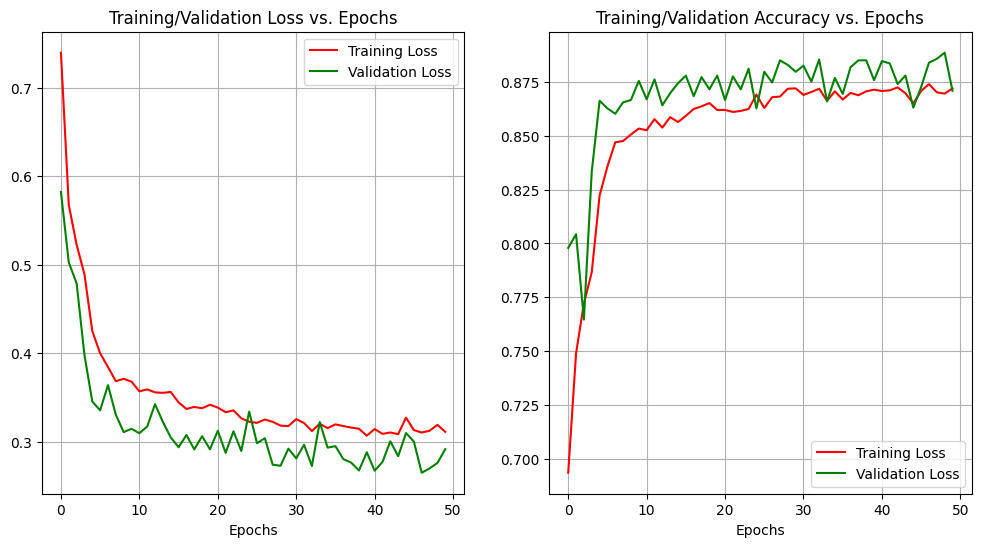

In [31]:
fig, axs = plt.subplots(1,2, figsize = (12,6))

axs[0].plot([epoch for epoch in range(EPOCHS)], train_loss_lst, color = 'r', label = 'Training Loss')
axs[0].plot([epoch for epoch in range(EPOCHS)], val_loss_lst, color = 'g', label = 'Validation Loss')
axs[0].legend()
axs[0].set_title('Training/Validation Loss vs. Epochs')
axs[0].set_xlabel('Epochs')
# axs[0].ylim([0,1])
axs[0].grid(which = 'both')


axs[1].plot([epoch for epoch in range(EPOCHS)], train_acc_lst, color = 'r', label = 'Training Loss')
axs[1].plot([epoch for epoch in range(EPOCHS)], val_acc_lst, color = 'g', label = 'Validation Loss')
axs[1].legend()
axs[1].set_title('Training/Validation Accuracy vs. Epochs')
axs[1].set_xlabel('Epochs')
# axs[1].ylim([0,1])
axs[1].grid(which = 'both')
# plt.savefig('GCNConvTrainingLoss_TestAccuracy.png', dpi=300)
plt.show()

# Hyperparameter Tuning

In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import numpy as np
from tqdm import tqdm
import traceback
import copy


def hyperparameter_tuning_cv(
    model_class,
    train_dataset: list[Data],
    param_grid: dict,
    n_splits: int = 5,
    num_epochs: int = 50,
    batch_size: int = 32,
    default_model_args: dict = None, # Base arguments for model instantiation
    default_optimizer_args: dict = None, # Base arguments for optimizer
    optimizer_class=torch.optim.AdamW, # Default optimizer
    criterion=torch.nn.BCEWithLogitsLoss(), # Default loss
    scoring_metric: str = 'auc', # 'auc', 'accuracy', 'f1', etc.
    device: torch.device = None,
    random_state_cv: int = 42 # For KFold reproducibility
):
    """
    Performs hyperparameter tuning using K-fold cross-validation, similar to GridSearchCV.

    Args:
        model_class: The class of the GNN model to be tuned (e.g., GCNClassifier).
        train_dataset (list[Data]): The full training dataset (will be split into train/val by KFold).
        param_grid (dict): Dictionary with parameters names (str) as keys and lists of
                           parameter settings to try as values.
        n_splits (int): Number of folds for K-fold cross-validation.
        num_epochs (int): Number of epochs to train for each hyperparameter combination.
        batch_size (int): Batch size for training and validation.
        default_model_args (dict, optional): Default arguments for instantiating the model.
                                            Parameters from param_grid will override these.
        default_optimizer_args (dict, optional): Default arguments for instantiating the optimizer.
                                                Parameters from param_grid can override these.
        optimizer_class: The PyTorch optimizer class to use.
        criterion: The loss function.
        scoring_metric (str): The metric to use for evaluating and selecting the best parameters
                              ('auc', 'accuracy', 'f1').
        device (torch.device, optional): Device to train on. If None, uses CUDA if available.
        random_state_cv (int): Random state for KFold for reproducible splits.

    Returns:
        tuple: (best_params, best_score, all_results)
            - best_params (dict): The hyperparameter combination that yielded the best score.
            - best_score (float): The best average score achieved on the validation sets.
            - all_results (list[dict]): A list of dictionaries, each containing the parameters
                                        tried and their corresponding validation scores for each fold.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Starting hyperparameter tuning on device: {device}")
    print(f"Scoring metric: {scoring_metric.upper()}")

    if default_model_args is None: default_model_args = {}
    if default_optimizer_args is None: default_optimizer_args = {}

    grid = ParameterGrid(param_grid)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state_cv)

    best_score = -float('inf') if scoring_metric in ['auc', 'accuracy', 'f1'] else float('inf')
    best_params = None
    all_results = []

    num_combinations = len(list(grid))
    print(f"Total hyperparameter combinations to try: {num_combinations}")

    for i, params in enumerate(grid):
        print(f"\n--- Combination {i+1}/{num_combinations} ---")
        print(f"Parameters: {params}")

        current_model_args = default_model_args.copy()
        current_optimizer_args = default_optimizer_args.copy()

        # Separate model and optimizer params from the grid
        model_specific_params = {}
        optimizer_specific_params = {}
        other_params = {} 

        
        for key, value in params.items():
            if key in default_model_args or any(key.startswith(p) for p in ['hidden_dim', 'num_graph_features', 'dropout', 'num_lgeb_layers']):
                model_specific_params[key] = value
            elif key in default_optimizer_args or any(key.startswith(p) for p in ['lr', 'learning_rate', 'weight_decay']):
                optimizer_specific_params[key] = value
            else:
                other_params[key] = value # e.g., if tuning batch_size itself

        current_model_args.update(model_specific_params)
        current_optimizer_args.update(optimizer_specific_params)

        # Allow batch_size to be tuned if present in 'other_params'
        current_batch_size = other_params.get('batch_size', batch_size)

        fold_scores = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
            print(f"  Fold {fold+1}/{n_splits}")

            # --- Prepare data for this fold ---
            # Ensure train_dataset is a list or sliceable
            try:
                 fold_train_dataset = [train_dataset[i] for i in train_idx]
                 fold_val_dataset = [train_dataset[i] for i in val_idx]
            except TypeError:
                 print("Error: train_dataset must be a list of PyG Data objects for KFold indexing.")
                 return None, float('-inf'), []


            train_loader = DataLoader(fold_train_dataset, batch_size=current_batch_size, shuffle=True)
            val_loader = DataLoader(fold_val_dataset, batch_size=current_batch_size, shuffle=False)

            # --- Instantiate Model and Optimizer ---
            try:
                model = model_class(**current_model_args).to(device)
                optimizer = optimizer_class(model.parameters(), **current_optimizer_args)
            except Exception as e:
                print(f"    Error instantiating model/optimizer with params {current_model_args}, {current_optimizer_args}: {e}")
                traceback.print_exc()
                fold_scores.append(np.nan)
                continue

            # --- Training Loop for this fold ---
            # for epoch in range(num_epochs):
            #     model.train()
            #     epoch_loss = 0
            #     for batch_data in train_loader: # Assuming train_loader yields PyG Batch objects
            #         batch_data = batch_data.to(device)
            #         optimizer.zero_grad()
            #         out = model(batch_data)
            #         loss = criterion(out.squeeze(), batch_data.y.float().squeeze()) # Ensure target is float for BCE
            #         loss.backward()
            #         optimizer.step()
            #         epoch_loss += loss.item()
            train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, epoch, log_interval_train)
            val_loss, val_acc, val_auc, val_report = evaluate_model(model, val_loader, criterion, device, epoch)


            # --- Evaluation on Validation Set for this fold ---
            model.eval()
            all_preds = []
            all_labels = []
            val_loss_sum = 0
            with torch.no_grad():
                for batch_data in val_loader:
                    batch_data = batch_data.to(device)
                    out = model(batch_data)
                    val_loss_sum += criterion(out.squeeze(), batch_data.y.float().squeeze()).item()
                    # Store predictions and labels for metrics
                    all_preds.extend(out.squeeze().cpu().tolist()) # Get probabilities
                    all_labels.extend(batch_data.y.cpu().tolist())

            avg_val_loss = val_loss_sum / len(val_loader)
            all_preds = np.array(all_preds)
            all_labels = np.array(all_labels)

            # Calculate scoring metric
            score = np.nan
            try:
                if scoring_metric == 'auc':
                    score = roc_auc_score(all_labels, all_preds)
                elif scoring_metric == 'accuracy':
                    score = accuracy_score(all_labels, (all_preds >= 0.5).astype(int))
                elif scoring_metric == 'f1':
                    score = f1_score(all_labels, (all_preds >= 0.5).astype(int), zero_division=0)
                # Add more metrics if needed
                else:
                    print(f"    Warning: Unknown scoring metric '{scoring_metric}'. Using AUC.")
                    score = roc_auc_score(all_labels, all_preds)
                fold_scores.append(score)
                print(f"    Fold {fold+1} Val Loss: {avg_val_loss:.4f}, Val {scoring_metric.upper()}: {score:.4f}")
            except ValueError as e:
                print(f"    Warning: Could not calculate {scoring_metric} for fold {fold+1}: {e}")
                fold_scores.append(np.nan)


        # --- Average score over folds for this parameter combination ---
        # Remove NaNs before averaging if any fold failed
        valid_fold_scores = [s for s in fold_scores if not np.isnan(s)]
        if valid_fold_scores:
            mean_score = np.mean(valid_fold_scores)
            print(f"  Average Validation {scoring_metric.upper()} for params: {mean_score:.4f}")
        else:
            mean_score = -float('inf') if scoring_metric in ['auc', 'accuracy', 'f1'] else float('inf')
            print(f"  No valid scores obtained for this parameter combination across folds.")


        all_results.append({
            'params': params,
            'mean_validation_score': mean_score,
            'individual_fold_scores': fold_scores
        })

        # Update best score and params
        if (scoring_metric in ['auc', 'accuracy', 'f1'] and mean_score > best_score) or \
           (scoring_metric not in ['auc', 'accuracy', 'f1'] and mean_score < best_score): # For loss-like metrics
            best_score = mean_score
            best_params = params
            print(f"  *** New Best Score: {best_score:.4f} with params: {best_params} ***")

    print("\n--- Hyperparameter Tuning Complete ---")
    if best_params:
        print(f"Best parameters found: {best_params}")
        print(f"Best average validation {scoring_metric.upper()}: {best_score:.4f}")
    else:
        print("No best parameters found (all combinations might have failed or produced NaN scores).")

    return best_params, best_score, all_results


# --- Example Usage (Illustrative - adapt to your actual model and data) ---
if __name__ == '__main__':
    param_grid = {
        'hidden_dim': [32, 64],
        'lr': [0.001, 0.0005],
        'dropout': [0.3, 0.5],
        'batch_size': [32, 64],
        'num_graph_features': [0, 2],
        'num_lgeb_layers':[3, 6]
        
    }
    # 4. Define default arguments for your model and optimizer
    # These are args that are NOT being tuned but are needed for instantiation.
    default_model_args_example = {
        'scalar_feature_dim': 4, 
        'edge_feature_dim': 1
    }
    default_optimizer_args_example = {
        'weight_decay': 1e-5
    }

    # 5. Run the tuning
    best_params_found, best_val_score, all_run_results = hyperparameter_tuning_cv(
        model_class=LorentzNet,
        train_dataset=train_dataset,
        param_grid=param_grid,
        n_splits=3,
        num_epochs=10,
        batch_size=32,
        default_model_args=default_model_args_example,
        default_optimizer_args=default_optimizer_args_example,
        optimizer_class=torch.optim.AdamW,
        criterion=torch.nn.BCELoss(),
        scoring_metric='auc',
        random_state_cv=seed
    )

    print("\n--- Tuning Summary ---")
    if best_params_found:
        print(f"Best Parameters: {best_params_found}")
        print(f"Best Validation AUC: {best_val_score:.4f}")

    # print("\nAll Results:")
    # for res in all_run_results:
    #     print(f"  Params: {res['params']}, Mean Score: {res['mean_validation_score']:.4f}, Fold Scores: {res['individual_fold_scores']}")

Starting hyperparameter tuning on device: cpu
Scoring metric: AUC
Total hyperparameter combinations to try: 64

--- Combination 1/64 ---
Parameters: {'batch_size': 32, 'dropout': 0.3, 'hidden_dim': 32, 'lr': 0.001, 'num_graph_features': 0, 'num_lgeb_layers': 3}
  Fold 1/3


RuntimeError: mat1 and mat2 shapes cannot be multiplied (142x3 and 4x32)